<a href="https://colab.research.google.com/github/pierrebrd/MI201_Projet/blob/main/Projet_MI01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes temporaires

Objectif : combiner l'attaque adversaire en segmentation avec la classification.

On va attaquer de la classification, ya un bail de segmentation (pas segmentation fault j'espère)

regarder TP adversaire : [https://colab.research.google.com/drive/1_H12sYUQpV5nTrT20N3zqKjYPCG62lOD?usp=sharing](https://colab.research.google.com/drive/1_H12sYUQpV5nTrT20N3zqKjYPCG62lOD?usp=sharing)


### Patch en segmentation ou classification

    Dans certains modèles, une image est divisée en plusieurs patches qui sont analysés indépendamment ou conjointement.
    Par exemple :
        ViT (Vision Transformer) : Divise une image en petits patches qui servent de "tokens" d'entrée pour le modèle, similaire aux mots dans le traitement du langage naturel.
        Segmentation : Les patches peuvent être utilisés pour prédire les étiquettes pixel par pixel en se basant sur l'information locale.


### Patch adversaire

Un patch adversaire est une forme spécifique d'attaque adversaire. C'est une petite région de l'image modifiée pour induire des erreurs dans les prédictions d'un modèle.
Un patch noir ne perturbe pas le réseau.

In [ ]:
%autosave 10

Autosaving every 10 seconds


# Prise en main segmentation

<ipython-input-2-6c54c7428a67>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load("coco_sample.pth") # On importe les données


torch.Size([9, 3, 520, 520])


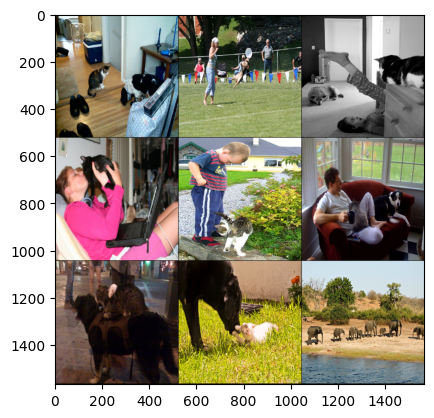

In [ ]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt

if not os.path.isfile("coco_sample.pth"): # Si le fichier n'est pas déjà téléchargé
  os.system("wget https://httpmail.onera.fr/21/ceb6b35731a7561b4b34355f1803dbfdCufzJD/coco_sample.pth") # On le télécharge

img = torch.load("coco_sample.pth") # On importe les données
print(img.shape) # On a 9 images RGB 520x520

visu = torchvision.utils.make_grid(img,nrow=3) # On met les images en grille
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2) # Permutation des entrées pour pouvoir les afficher avec plt.imshow()
plt.imshow(visu.numpy())
plt.show()

les 9 images étant chargées, on peut leur appliquer un modèle deeplab pré-appris comme
torchvision.models.segmentation.DeepLabV3_ResNet50_Weights

In [ ]:
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1 # On charge les poids
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval() # On crée le réseau avec les poids que l'on a déja chargé

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) # Pour normaliser les images, les adapter à ce que le modèle à appris ?

with torch.no_grad(): # On n'entraine pas le modèle
  x = normalize(img) # Normalisation de l'image
  z = net(x)["out"] # on prédit des cartes de score de confiance
  z = z[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,z = z.max(1) # on prend le meilleur score

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (z==1).float() # red for cat
pred[:,1,:,:] = (z==2).float() # green for dog
pred[:,2,:,:] = (z==3).float() # blue for person

visu = torch.cat([img,pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

Le résultat est loin d'être parfait mais on voit que le réseau est "fonctionnel" (il s'agit d'un backbone resnet - au fait beaucoup mieux aujourd'hui mais il faut aller chercher les modèles ailleurs...).

On peut en tester un autre plus rapide (et moins bon) comme torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights:

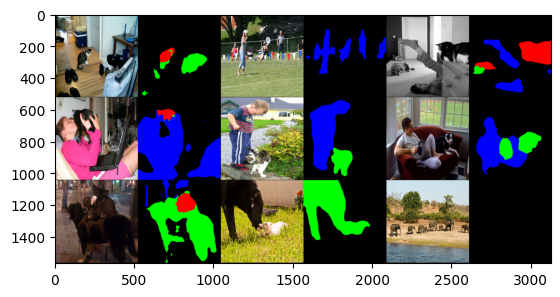

In [ ]:
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  z = net(x)["out"] # on prédit des cartes de score de confiance
  z = z[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,z = z.max(1) # on prend le meilleur score

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (z==1).float() # red for cat
pred[:,1,:,:] = (z==2).float() # green for dog
pred[:,2,:,:] = (z==3).float() # blue for person

visu = torch.cat([img,pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()